In [1]:
#Character Dialogue Prediction notebookd
# 
# 4-character-dialogue_prediction


In [2]:
#predict what character said what diagloue on a per episode basis
#import packages

import pandas as pd
import numpy as np
import re

#for web scraping
from bs4 import BeautifulSoup
import requests

#for tokenization
from nltk import sent_tokenize, word_tokenize
import spacy
from spacy.pipeline import Sentencizer
from spacy.lang.en import English

#for sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# For visualization.
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

#for bag of words model vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#to evaluate which document most aligns with a given vector/token
from sklearn.metrics.pairwise import cosine_similarity



from gensim import models, corpora
from gensim import similarities
from gensim.models.coherencemodel import CoherenceModel
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import StratifiedShuffleSplit

In [3]:
#import data
atla_df = pd.read_csv('/Users/justin/Documents/Personal/projects/atla_nlp/data/processed/atla_df.csv', keep_default_na=False, index_col=0)
#keep_default_na=False prevent empty strings from being read as NaN

In [4]:
atla_df

,book_num,book_name,episode_num,episode_name,link,Aang,Iroh,Katara,Sokka,Toph,Zuko
0,1.0,Book One: Water,1,The Boy in the Iceberg,https://avatar.fandom.com/wiki/Transcript:The_...,[In a weak voice.] I need to ask you something...,[He is playing some sort of card game. He answ...,[Narrating.] Water. Earth. Fire. Air. My grand...,It's not getting away from me this time. [Clos...,,Finally! [He turns around to face another pers...
1,1.0,Book One: Water,2,The Avatar Returns,https://avatar.fandom.com/wiki/Transcript:The_...,"[Sheepishly, as Katara glares at Sokka.] Yeah....",[Turns to one of Zuko's men and gives him the ...,"Water. Earth. Fire. Air. Long ago, the four na...",[Angrily.] I knew it! [Accusingly points a fin...,,[Angrily.] Where are you hiding him?[Shaking K...
2,1.0,Book One: Water,3,The Southern Air Temple,https://avatar.fandom.com/wiki/Transcript:The_...,"[Excitedly.] Wait 'til you see it, Katara! The...",[Disinterested.] You mean the Avatar?[Bows bac...,"[Cautiously.] Aang, I know you're excited, [Sh...",[Grunting sleepily.] Uggh! Sleep now. Temple l...,,"Uncle, I want the repairs made as quickly as p..."
3,1.0,Book One: Water,4,The Warriors of Kyoshi,https://avatar.fandom.com/wiki/Transcript:The_...,Well ... [Happily.] I know it's near water.Mom...,[Pushes open the door completely and enters th...,"[Nonchalantly, still focusing on her task at h...",[To Aang.] You have no idea where you're going...,,[Calmly.] The only reason you should be interr...
4,1.0,Book One: Water,5,The King of Omashu,https://avatar.fandom.com/wiki/Transcript:The_...,The Earth Kingdom city of Omashu! [Camera pans...,,[Close-up; impressed.] Wow. We don't have buil...,[Close-up; overwhelmed.] They have buildings h...,,
...,...,...,...,...,...,...,...,...,...,...,...
56,3.0,Book Three: Fire,57,The Southern Raiders,https://avatar.fandom.com/wiki/Transcript:The_...,[To Zuko.] What are you doing?[In the backgrou...,,"[Angrily.] What are you doing?Okay, I'm not cr...",Come on! We've gotta get out of here!We need t...,[Pointing to the exit.] Come on! We can get ou...,[As he runs and pushes her out of harm's way.]...
57,3.0,Book Three: Fire,58,The Ember Island Players,https://avatar.fandom.com/wiki/Transcript:The_...,[To Zuko; points to his seat and tries to act ...,"[Looking toward Actor Zuko, at ease.] Prince Z...",Doesn't it seem kind of weird that we're hidin...,You guys are not gonna believe this! There's a...,Why are we sitting in the nosebleed section? M...,"I told you, [Cut to Zuko sitting on a dry foun..."
58,3.0,Book Three: Fire,59,"Sozin's Comet, Part 1",https://avatar.fandom.com/wiki/Transcript:Sozi...,[Stops firebending and turns to Zuko while gro...,,[Holding up two watermelons.] Who wants a nice...,Maybe Zuko's right. Sitting around the house h...,"Not bad, baldy, [Aang jumps off the sculpture....",More ferocious! Imagine striking through your ...
59,3.0,Book Three: Fire,60,"Sozin's Comet, Part 2",https://avatar.fandom.com/wiki/Transcript:Sozi...,"Where are we, Momo? [Cut to view of the sky th...",[Close-up.] I was never angry with you. I was ...,[Angrily.] I'm not his girlfriend![Pulls out A...,"[To Zuko.] Hey, I remember her! [Cut to fronta...",[Frontal view.] We know he's gone. That's why ...,Yup. [Walks forward.] Back in the good old day...


In [5]:
atla_lines_df = pd.read_csv('/Users/justin/Documents/Personal/projects/atla_nlp/data/raw/atla_lines.csv', keep_default_na=False, index_col=0)
atla_lines_df

,episode_num,character_name,character_lines
0,1,Katara,[Narrating.] Water. Earth. Fire. Air. My grand...
1,1,Sokka,It's not getting away from me this time. [Clos...
2,1,Aang,[In a weak voice.] I need to ask you something...
3,1,Toph,
4,1,Zuko,Finally! [He turns around to face another pers...
...,...,...,...
361,61,Sokka,We're too late! The fleet's already taking off...
362,61,Aang,"Momo, time for you to go.Please listen to me. ..."
363,61,Toph,Too bad the Fire Lord's about to use it to des...
364,61,Zuko,It's not her I'm worried about. I'm worried ab...


In [26]:
#drop rows where character_lines is empty
atla_lines_df = atla_lines_df[atla_lines_df['character_lines'] != '']

In [55]:
atla_lines_df

,episode_num,character_name,character_lines
0,1,Katara,[Narrating.] Water. Earth. Fire. Air. My grand...
1,1,Sokka,It's not getting away from me this time. [Clos...
2,1,Aang,[In a weak voice.] I need to ask you something...
4,1,Zuko,Finally! [He turns around to face another pers...
5,1,Iroh,[He is playing some sort of card game. He answ...
...,...,...,...
361,61,Sokka,We're too late! The fleet's already taking off...
362,61,Aang,"Momo, time for you to go.Please listen to me. ..."
363,61,Toph,Too bad the Fire Lord's about to use it to des...
364,61,Zuko,It's not her I'm worried about. I'm worried ab...


In [27]:
#split into train and test sets
X = atla_lines_df.iloc[:,2]
y = atla_lines_df.iloc[:,1]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss.get_n_splits(X, y)

for i, (train_index, test_index) in enumerate(sss.split(X, y)):

    #train and validate data splits with their labels
    train_data = X.iloc[train_index]
    train_data_labels = y.iloc[train_index]

    test_data = X.iloc[test_index]
    test_data_labels = y.iloc[test_index]

(array([46.,  0., 37.,  0., 46.,  0., 48.,  0., 27., 29.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

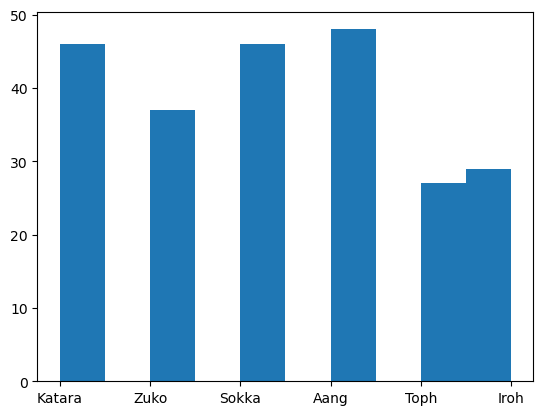

In [28]:
#plot distribution of labels in train and test sets
plt.hist(train_data_labels)


(array([ 9.,  0., 12.,  0., 12.,  0., 12.,  0.,  7.,  7.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

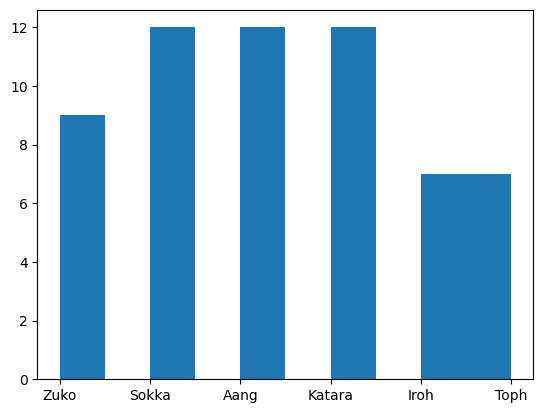

In [29]:
plt.hist(test_data_labels)

In [30]:
import collections
print("train data: ", collections.Counter(train_data_labels))
print("test data: ", collections.Counter(test_data_labels))

train data:  Counter({'Aang': 48, 'Katara': 46, 'Sokka': 46, 'Zuko': 37, 'Iroh': 29, 'Toph': 27})
test data:  Counter({'Sokka': 12, 'Aang': 12, 'Katara': 12, 'Zuko': 9, 'Iroh': 7, 'Toph': 7})


In [101]:
train_data_labels

24     Katara
108    Katara
10       Zuko
133     Sokka
232      Zuko
        ...  
98       Aang
18     Katara
80       Aang
12     Katara
167      Iroh
Name: character_name, Length: 233, dtype: object

In [110]:
#one hot encode labels
y_train = pd.get_dummies(train_data_labels).to_numpy()
y_test = pd.get_dummies(test_data_labels).to_numpy()

In [62]:
#use regular Keras tokenizer, just filter out numbers and certain symbols
#limit to moct frequent 5,000 words (focuses on most common words, ignores rare words)

tokenizer = keras.preprocessing.text.Tokenizer(num_words=5000,
                                               filters='0123456789!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
                                               lower=True)

In [67]:
tokenizer.num_words

5000

In [68]:
%%time
tokenizer.fit_on_texts(train_data)
#fit on train data only

CPU times: user 35 ms, sys: 1.81 ms, total: 36.8 ms
Wall time: 36 ms


In [69]:
#number of training examples
tokenizer.document_count

466

In [70]:
X_train = tokenizer.texts_to_sequences(train_data)
#vecotrize train data

CPU times: user 22.5 ms, sys: 548 µs, total: 23 ms
Wall time: 22.7 ms


In [71]:
# The first cahracter dialogue in the training set, vectorized.
print(X_train[0])

[89, 15, 1292, 440, 16, 33, 36, 1690, 53, 18, 9, 1, 1293, 497, 2539, 25, 248, 29, 2, 28, 2540, 12, 24, 25, 1130, 160, 12, 8, 108, 38, 778, 57, 152, 116, 29, 49, 1, 83, 1691, 19, 27, 2541, 12, 11, 249, 264, 944, 640, 2542, 2543, 254, 2, 498, 4, 3433, 16, 131, 2544, 8, 2545, 53, 356, 19, 303, 88, 1692, 2, 5, 3434, 587, 81, 2546, 945, 1, 3435, 7, 1, 3436, 23, 67, 14, 20, 51, 20, 1033, 2, 36, 641, 12, 697, 423, 3437, 1, 946, 7, 1, 2005, 2006, 8, 56, 1, 2547, 19, 5, 3438, 2007, 357, 34, 2008, 29, 25, 304, 1034, 3439, 888, 888, 3440, 698, 12, 35, 104, 499, 39, 467, 1035, 2, 12, 11, 8, 31, 22, 186, 105, 3441, 24, 25, 3442, 500, 642, 25, 338, 3443, 1, 255, 11, 330, 11, 18, 2009, 2010, 5, 139, 3444, 947, 4, 75, 256, 72, 51, 198, 72, 257, 18, 11, 5, 779, 699, 23, 30, 42, 254, 563, 85, 43, 1294, 93, 2, 116, 29, 132, 94, 2, 38, 82, 101, 29, 7, 51, 1693, 106, 25, 780, 86, 46, 468, 2548, 60, 8, 67, 54, 82, 347, 12, 12, 144, 155, 10, 780, 78, 53, 408, 71, 8, 32, 1131, 145, 274, 1, 3445, 833, 3446, 26

In [72]:
# Review excerpt reconstructed from integer sequence.
tokenizer.sequences_to_texts([X_train[0]])[0][:300]

"close up impressed wow we don't have buildings like this in the south pole stretching her arm out to him halting aang with her cry wait aang it could be dangerous if people find out you're the avatar glancing at sokka technically aang is years old waving hi june pippinpaddleopsicopolis nice to meet "

In [73]:
# Original review text.
train_data.iloc[0][:300]

"[Close-up; impressed.] Wow. We don't have buildings like this in the South Pole![Stretching her arm out to him, halting Aang with her cry.] Wait, Aang! It could be dangerous if people find out you're the Avatar.[Glancing at Sokka.] Technically, Aang is 112 years old.[Waving.] Hi. June Pippinpaddleop"

In [80]:
#identify length of longest sequence in train set to perform padding
max_len = max([len(x) for x in X_train])

In [81]:
max_len

1595

In [82]:
MAX_SEQ_LEN = max_len
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=MAX_SEQ_LEN)

In [83]:
print(X_train[0])

[  0   0   0 ... 264 348 458]


In [84]:
#vectorize and pad test set
X_test = tokenizer.texts_to_sequences(test_data)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_SEQ_LEN)

In [108]:
X_test

array([[  0,   0,   0, ...,  87, 512, 120],
       [  0,   0,   0, ..., 237, 128, 188],
       [  0,   0,   0, ...,  17,  10, 203],
       ...,
       [  0,   0,   0, ..., 351, 147,   2],
       [  0,   0,   0, ...,  74,   2,  35],
       [  0,   0,   0, ...,   3, 472,   4]], dtype=int32)

In [86]:
#import pre-trained word vectors (Google word2Vec on News corpora)
embedding_file = '/Users/justin/Documents/Personal/projects/atla_nlp/data/external/GoogleNews-vectors-negative300.bin.gz'


In [87]:
from gensim.models.keyedvectors import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format(embedding_file, binary=True, limit=200000)

In [90]:
#example word vector retreival
avatar = word_vectors['avatar']
print(f'Vector dimension: {avatar.shape}')

# The embedding for the word 'avatar'.
print(avatar)

Vector dimension: (300,)
[ 0.53515625 -0.06689453 -0.06445312  0.16210938 -0.3203125   0.20019531
 -0.05004883 -0.18652344  0.12011719 -0.12695312 -0.06347656  0.16699219
  0.23828125 -0.20410156 -0.18847656  0.28320312  0.12304688  0.04174805
  0.03088379 -0.33398438  0.05200195  0.01000977  0.09863281  0.21679688
 -0.33007812  0.20703125 -0.45703125  0.20117188  0.07714844 -0.24023438
 -0.04956055 -0.05297852 -0.26171875  0.10791016 -0.05126953 -0.42773438
  0.34375     0.04443359 -0.09765625 -0.06591797  0.18066406 -0.05712891
 -0.24023438  0.48632812  0.2890625  -0.5078125   0.0246582  -0.05737305
  0.25390625 -0.1015625  -0.0859375  -0.06298828  0.07470703 -0.00665283
 -0.0456543  -0.09814453  0.11914062 -0.12060547  0.19042969 -0.21289062
  0.05566406 -0.00091171 -0.09277344 -0.09277344 -0.33203125  0.59765625
 -0.04541016 -0.02001953  0.05859375  0.24902344  0.03125     0.39257812
 -0.29882812 -0.19335938 -0.12255859 -0.3125      0.27734375 -0.01220703
 -0.15625     0.01660156  

In [91]:
#incorporate pre-trained word vectors into embedding layer
# + 1 to account for padding token.
num_tokens = len(tokenizer.word_index) + 1

embedding_dim = 300
embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in tokenizer.word_index.items():
  if word_vectors.has_index_for(word):
    embedding_matrix[i] = word_vectors[word].copy()

In [94]:
# Quick check
print(embedding_matrix[tokenizer.word_index['avatar']][:50])

[ 0.53515625 -0.06689453 -0.06445312  0.16210938 -0.3203125   0.20019531
 -0.05004883 -0.18652344  0.12011719 -0.12695312 -0.06347656  0.16699219
  0.23828125 -0.20410156 -0.18847656  0.28320312  0.12304688  0.04174805
  0.03088379 -0.33398438  0.05200195  0.01000977  0.09863281  0.21679688
 -0.33007812  0.20703125 -0.45703125  0.20117188  0.07714844 -0.24023438
 -0.04956055 -0.05297852 -0.26171875  0.10791016 -0.05126953 -0.42773438
  0.34375     0.04443359 -0.09765625 -0.06591797  0.18066406 -0.05712891
 -0.24023438  0.48632812  0.2890625  -0.5078125   0.0246582  -0.05737305
  0.25390625 -0.1015625 ]


In [96]:
#build NN model architecture
#use Keras embedding layer with matrix of pre-trained word vectors
#set trainable to 'True' so that the embedding layer is updated during training

embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    input_length=MAX_SEQ_LEN,
    trainable=True
)

In [119]:
train_data_labels.nunique()

6

In [123]:
# For the output layer. The number of classes corresponds to the
# number of possible labels.
num_classes = train_data_labels.nunique()

In [124]:
tf.random.set_seed(0)

model = keras.Sequential()

# This layer will output a sequence of 300-dimension *vectors*, one for each element in the input sequence.
model.add(embedding_layer)

# This layer will calculate an average of those vectors.
model.add(layers.GlobalAveragePooling1D()) #each training example is sequence of vectors, but subsequent layers expect one vector per training example, this averages all word vectors in sequence

model.add(layers.Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))
model.add(layers.Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))
model.add(layers.Dense(num_classes, activation='softmax',kernel_initializer=tf.keras.initializers.random_normal(seed=1)))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [125]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1595, 300)         1830300   
                                                                 
 global_average_pooling1d_2  (None, 300)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_6 (Dense)             (None, 128)               38528     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 6)                 390       
                                                                 
Total params: 1877474 (7.16 MB)
Trainable params: 1877474 (7.16 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [136]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
8/8 [==============================] - 0s 16ms/step - loss: 1.2605 - accuracy: 0.4378
Epoch 2/20
8/8 [==============================] - 0s 15ms/step - loss: 1.2242 - accuracy: 0.4378
Epoch 3/20
8/8 [==============================] - 0s 14ms/step - loss: 1.1798 - accuracy: 0.3605
Epoch 4/20
8/8 [==============================] - 0s 15ms/step - loss: 1.1894 - accuracy: 0.4077
Epoch 5/20
8/8 [==============================] - 0s 16ms/step - loss: 1.1686 - accuracy: 0.4506
Epoch 6/20
8/8 [==============================] - 0s 15ms/step - loss: 1.1443 - accuracy: 0.4721
Epoch 7/20
8/8 [==============================] - 0s 16ms/step - loss: 1.0696 - accuracy: 0.5150
Epoch 8/20
8/8 [==============================] - 0s 15ms/step - loss: 1.0398 - accuracy: 0.5322
Epoch 9/20
8/8 [==============================] - 0s 15ms/step - loss: 1.0268 - accuracy: 0.5236
Epoch 10/20
8/8 [==============================] - 0s 15ms/step - loss: 1.0037 - accuracy: 0.5064
Epoch 11/20
8/8 [============

In [137]:
#poor performance on text set
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 9ms/step - loss: 1.7369 - accuracy: 0.3220


[1.7368565797805786, 0.32203391194343567]

In [75]:
#train word embeddings and model simultaneously to predict character dialogue ownership

In [76]:
tf.random.set_seed(0)

model = keras.Sequential()

# The 'trainable' property is True by default.
model.add(layers.Embedding(input_dim=num_tokens,
                           output_dim=embedding_dim,
                           input_length=MAX_REVIEW_LEN))


model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))
model.add(layers.Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))
model.add(layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.random_normal(seed=1)))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train, y_train, epochs=20, batch_size=512, Test_data=(X_val, y_val), callbacks=[es_callback])

NameError: name 'embedding_dim' is not defined